In [ ]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb
import warnings
warnings.filterwarnings("ignore")

In [115]:
# loading the dataset
df = pd.read_csv("ecommerce_sales.csv")
df.head()

,date,product_id,category,region,price,discount,cost,sales,revenue,day_of_week,is_promo_day
0,2020-04-11,1001,Home,South,298.91,0.18,245.1062,6,1470.64,5,0
1,2020-04-11,1002,Fashion,South,283.38,0.14,243.7068,7,1705.95,5,0
2,2020-04-11,1003,Electronics,North,289.58,0.00,289.5800,26,7529.08,5,0
3,2020-04-11,1004,Electronics,East,36.96,0.09,33.6336,27,908.11,5,0
4,2020-04-11,1005,Fashion,North,261.23,0.00,261.2300,17,4440.91,5,0


In [116]:
# Exploratory Data Analysis (EDA)
print("Dataset Information:")
df.info()
print("\nStatistics of the dataset:")
print(df.describe())
print("\nMissing values in the dataset:")
print(df.isnull().sum())
print("\nUnique values in categorical columns:")
print(df.select_dtypes(include=['object']).nunique())


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18260 entries, 0 to 18259
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          18260 non-null  object 
 1   product_id    18260 non-null  int64  
 2   category      18260 non-null  object 
 3   region        18260 non-null  object 
 4   price         18260 non-null  float64
 5   discount      18260 non-null  float64
 6   cost          18260 non-null  float64
 7   sales         18260 non-null  int64  
 8   revenue       18260 non-null  float64
 9   day_of_week   18260 non-null  int64  
 10  is_promo_day  18260 non-null  int64  
dtypes: float64(4), int64(4), object(3)
memory usage: 1.5+ MB

Statistics of the dataset:
        product_id         price      discount          cost         sales  \
count  18260.00000  18260.000000  18260.000000  18260.000000  18260.000000   
mean    1005.50000    256.817432      0.149161    218.432241     

In [117]:
# Convert 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'])

In [118]:
# Aggregate sales by date for time-series analysis
daily_sales = df.groupby('date')['sales'].sum().reset_index()

In [119]:
# Add time-based features
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['week_of_year'] = df['date'].dt.isocalendar().week

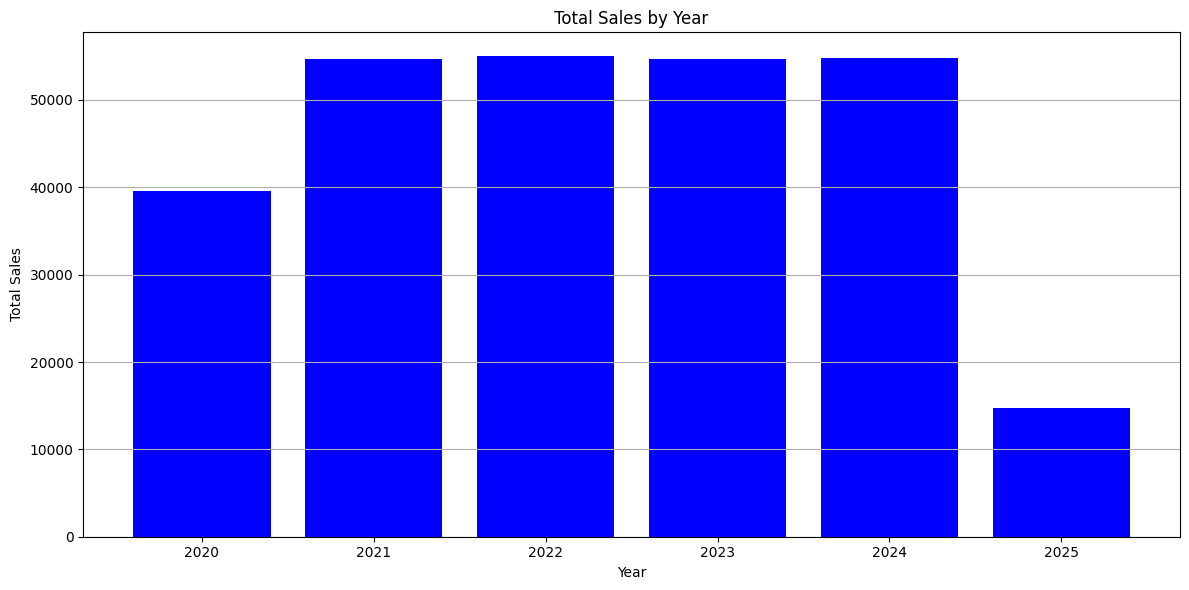

In [120]:
# 1.Aggregate sales by year
yearly_sales = df.groupby(df['date'].dt.year)['sales'].sum().reset_index()
yearly_sales.rename(columns={'date': 'year', 'sales': 'total_sales'}, inplace=True)

# Plot total sales by year
plt.figure(figsize=(12, 6))
plt.bar(yearly_sales['year'], yearly_sales['total_sales'], color='blue')
plt.title('Total Sales by Year')
plt.xlabel('Year')
plt.ylabel('Total Sales')
plt.grid(axis='y')
plt.tight_layout()
plt.show()
plt.savefig('total_sales_by_year.png')
plt.close()

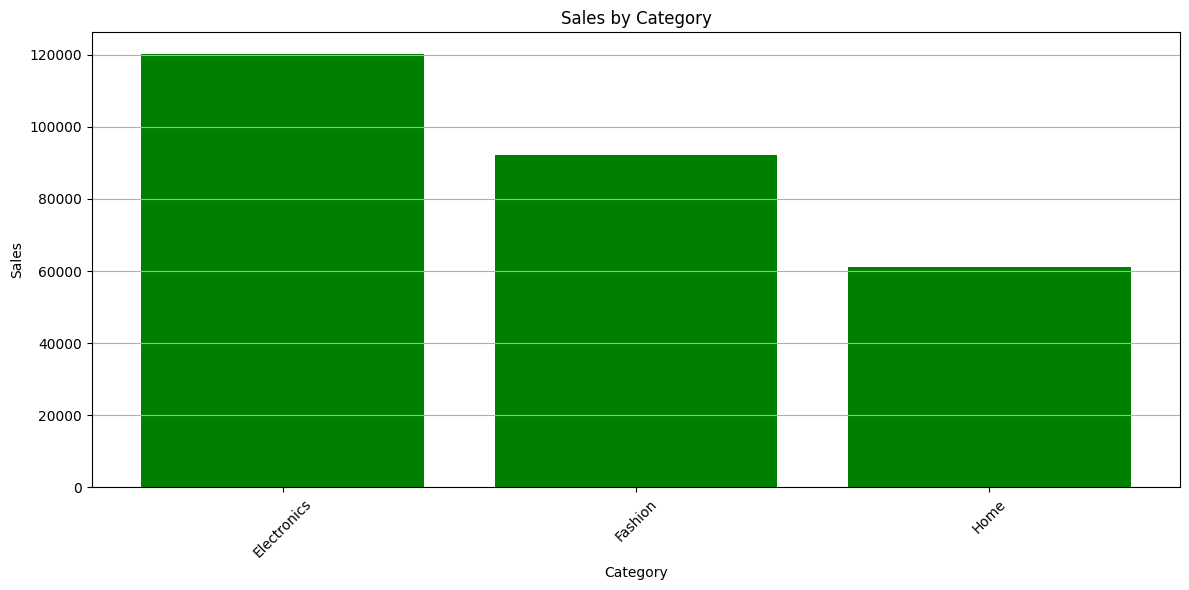

In [121]:
# 2. Sales by category
category_sales = df.groupby('category')['sales'].sum().reset_index()
category_sales.sort_values(by='sales', ascending=False, inplace=True)

# Plot sales by category
plt.figure(figsize=(12, 6))
plt.bar(category_sales['category'], category_sales['sales'], color='green')
plt.title('Sales by Category')
plt.xlabel('Category')
plt.ylabel('Sales')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()
plt.savefig('sales_by_category.png')
plt.close()

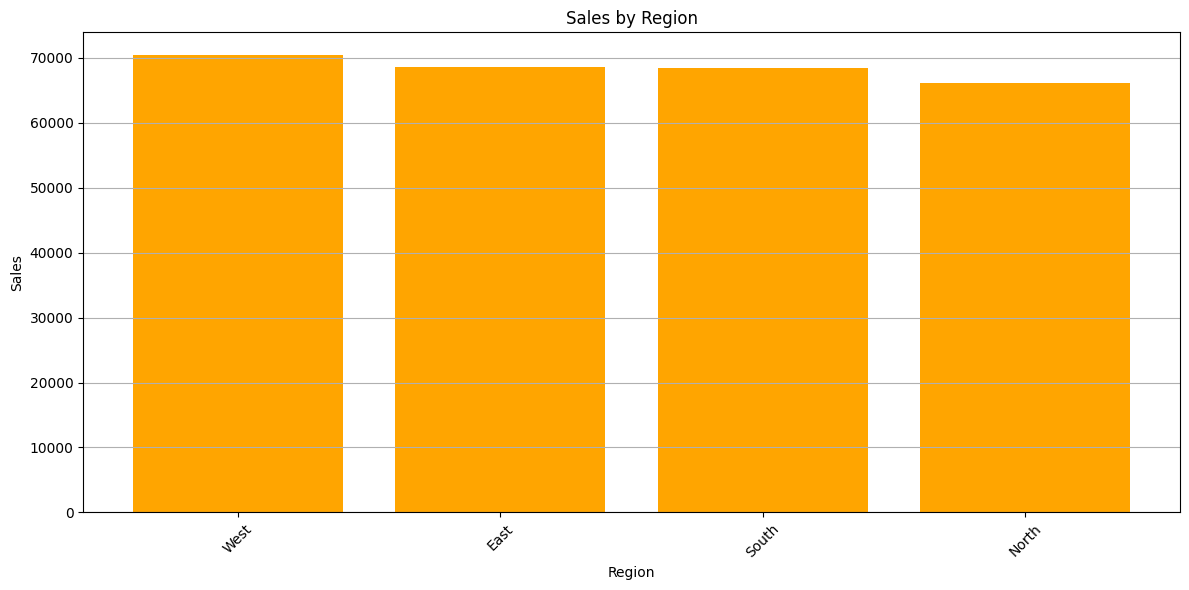

In [122]:
# 3. Sales by region
region_sales = df.groupby('region')['sales'].sum().reset_index()
region_sales.sort_values(by='sales', ascending=False, inplace=True)

# Plot sales by region
plt.figure(figsize=(12, 6))
plt.bar(region_sales['region'], region_sales['sales'], color='orange')
plt.title('Sales by Region')
plt.xlabel('Region')
plt.ylabel('Sales')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()
plt.savefig('sales_by_region.png')
plt.close()


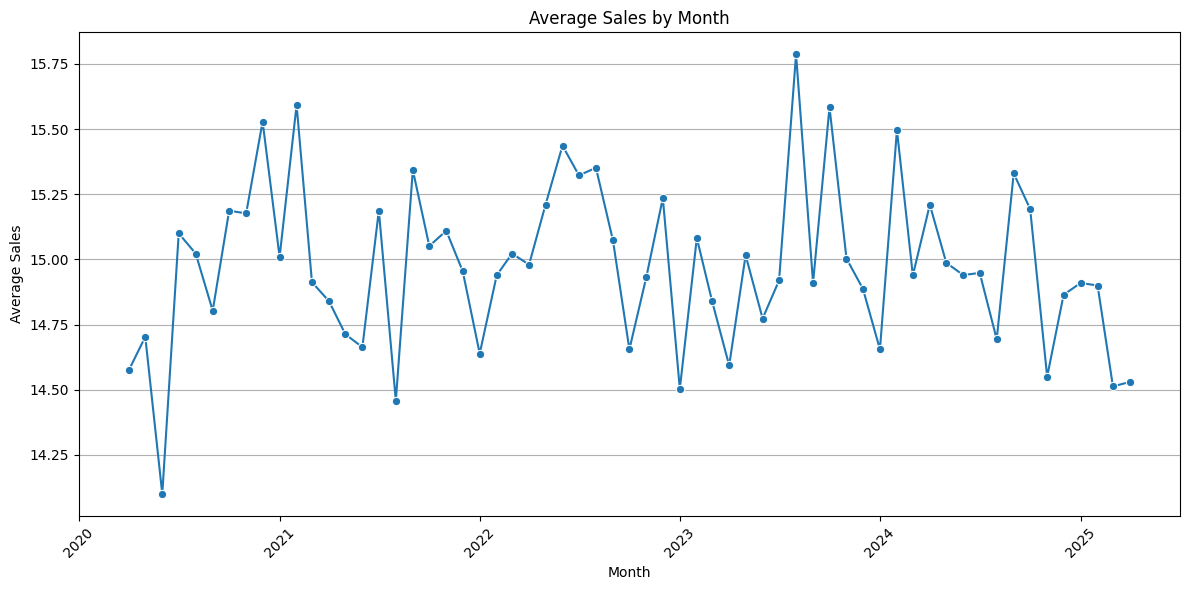

In [123]:
# 4. Avg Sales by month
monthly_sales = df.groupby(['year','month'])['sales'].mean().reset_index()
monthly_sales['date'] = pd.to_datetime(monthly_sales[['year', 'month']].assign(day=1))

# Plot average sales by month
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_sales, x='date', y='sales', marker='o')
plt.title('Average Sales by Month')
plt.xlabel('Month')
plt.ylabel('Average Sales')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()
plt.savefig('avg_sales_by_month.png')
plt.close()


In [124]:
# Encode categorical variables
df = pd.get_dummies(df, columns=['category', 'region'], drop_first=True)

In [125]:
# Lag features
df['lag_1'] = df.groupby('product_id')['sales'].shift(1)
df['lag_7'] = df.groupby('product_id')['sales'].shift(7)
df['lag_30'] = df.groupby('product_id')['sales'].shift(30)  # Added 30-day lag

# Rolling mean (7-day window)
df['rolling_mean_7'] = df.groupby('product_id')['sales'].shift(1).rolling(window=7).mean()

# Drop rows with NaN due to lagging
df = df.dropna()

In [126]:
# --- Prepare Data for XGBoost ---
features = ['year', 'month', 'day', 'week_of_year', 'price', 'discount', 'cost', 
            'day_of_week', 'is_promo_day', 'lag_1', 'lag_7', 'lag_30', 'rolling_mean_7'] + \
           [col for col in df.columns if col.startswith(('category_', 'region_'))]
target = 'sales'

In [127]:
X = df[features]
y = df[target]

In [128]:
# Split into train and test sets (last 20% as test)
train_size = int(len(X) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

In [129]:
models = {
    'Linear Regression': LinearRegression(),
    'XGBoost': xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42),
    'LightGBM': lgb.LGBMRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42, verbose=-1)
}

In [130]:
# Train models and evaluate
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    results[name] = {'model': model, 'rmse': rmse, 'y_pred': y_pred}
    print(f"{name} RMSE: {rmse:.2f}")

Linear Regression RMSE: 3.80
XGBoost RMSE: 3.83
Random Forest RMSE: 3.79
LightGBM RMSE: 3.83


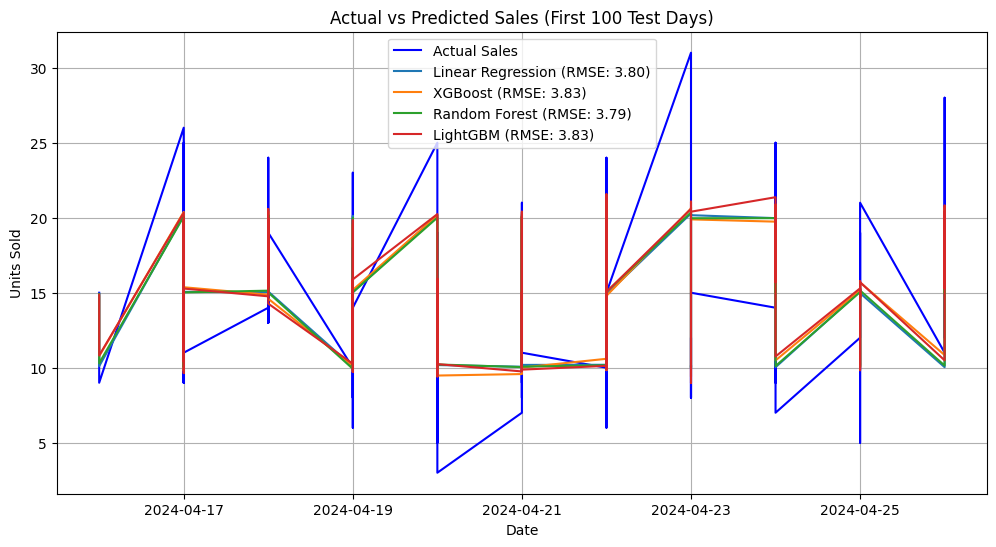

In [131]:
# 5. Actual vs Predicted Sales Comparison
test_dates = df['date'].iloc[train_size:].iloc[:100]
plt.figure(figsize=(12, 6))
plt.plot(test_dates, y_test[:100], label='Actual Sales', color='blue')
for name, res in results.items():
    plt.plot(test_dates, res['y_pred'][:100], label=f'{name} (RMSE: {res["rmse"]:.2f})')
plt.title('Actual vs Predicted Sales (First 100 Test Days)')
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.legend()
plt.grid(True)
plt.show()
plt.savefig('actual_vs_predicted_sales.png')
plt.close()

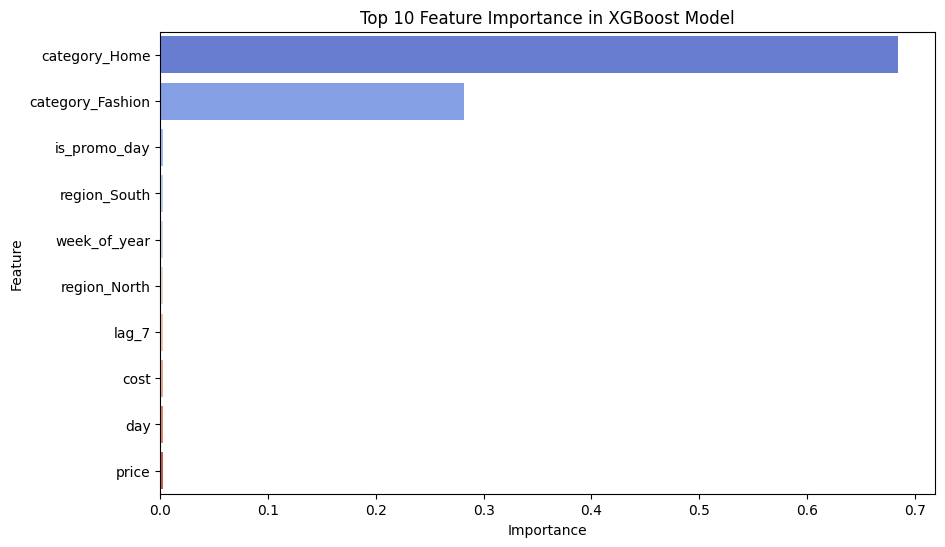

In [132]:
# 6. Feature Importance
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': results['XGBoost']['model'].feature_importances_
}).sort_values('importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(10), palette='coolwarm')
plt.title('Top 10 Feature Importance in XGBoost Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.savefig('feature_importance_xgboost.png')
plt.show()
plt.close()

In [133]:
# --- Forecast Future Sales (next 30 days) ---
last_date = df['date'].max()
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30, freq='D')
future_df = []

for date in future_dates:
    for product_id in df['product_id'].unique():
        last_row = df[df['product_id'] == product_id].iloc[-1]
        future_row = {
            'date': date,
            'product_id': product_id,
            'year': date.year,
            'month': date.month,
            'day': date.day,
            'week_of_year': date.isocalendar().week,
            'price': last_row['price'],
            'discount': 0,
            'cost': last_row['cost'],
            'day_of_week': date.weekday(),
            'is_promo_day': 0,
            'lag_1': df[df['product_id'] == product_id]['sales'].iloc[-1],
            'lag_7': df[df['product_id'] == product_id]['sales'].iloc[-7],
            'lag_30': df[df['product_id'] == product_id]['sales'].iloc[-30],
            'rolling_mean_7': df[df['product_id'] == product_id]['sales'].iloc[-7:].mean(),
        }
        for col in [c for c in df.columns if c.startswith(('category_', 'region_'))]:
            future_row[col] = last_row[col]
        future_df.append(future_row)

future_df = pd.DataFrame(future_df)
future_X = future_df[features]

In [134]:
# Generate forecasts for each model
forecast_dfs = {}
for name, res in results.items():
    future_pred = res['model'].predict(future_X)
    forecast_df = future_df[['date', 'product_id']].copy()
    forecast_df['predicted_sales'] = future_pred
    forecast_df.to_csv(f'sales_forecast_{name.lower().replace(" ", "_")}.csv', index=False)
    forecast_dfs[name] = forecast_df

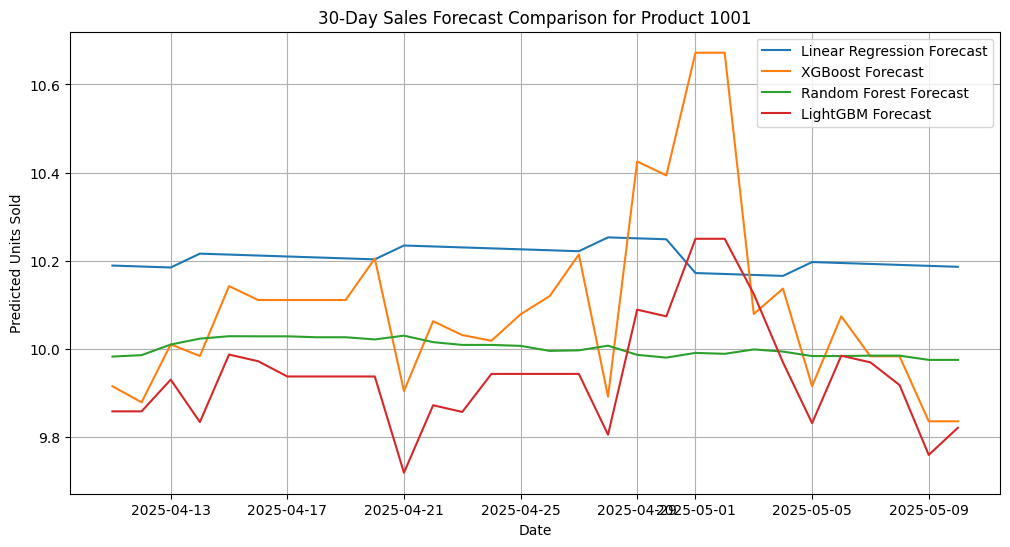

In [135]:
# 7. Forecast Comparison for Product 1001
product_id = 1001
plt.figure(figsize=(12, 6))
for name, forecast_df in forecast_dfs.items():
    product_forecast = forecast_df[forecast_df['product_id'] == product_id]
    plt.plot(product_forecast['date'], product_forecast['predicted_sales'], label=f'{name} Forecast')
plt.title(f'30-Day Sales Forecast Comparison for Product {product_id}')
plt.xlabel('Date')
plt.ylabel('Predicted Units Sold')
plt.legend()
plt.grid(True)
plt.show()
plt.savefig(f'forecast_comparison_product_{product_id}.png')
plt.close()

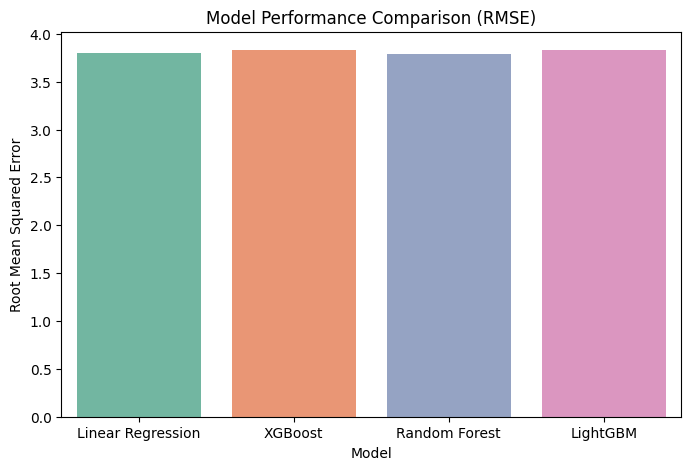

In [136]:
# 8. RMSE Comparison Bar Plot
rmse_df = pd.DataFrame([(name, res['rmse']) for name, res in results.items()], columns=['Model', 'RMSE'])
plt.figure(figsize=(8, 5))
sns.barplot(x='Model', y='RMSE', data=rmse_df, palette='Set2')
plt.title('Model Performance Comparison (RMSE)')
plt.ylabel('Root Mean Squared Error')
plt.show()
plt.savefig('model_performance_comparison.png')
plt.close()

In [137]:
print("Forecasts saved:")
for name in results.keys():
    print(f"- sales_forecast_{name.lower().replace(' ', '_')}.csv")
print("Model metrics saved to 'model_metrics.txt'")
print("Visualizations saved in 'visualizations/':")
print("- sales_trend.png")
print("- sales_by_category.png")
print("- sales_by_region.png")
print("- monthly_sales_trend.png")
print("- actual_vs_predicted_comparison.png")
print("- feature_importance_xgboost.png")
print("- forecast_comparison_product_1001.png")
print("- rmse_comparison.png")

Forecasts saved:
- sales_forecast_linear_regression.csv
- sales_forecast_xgboost.csv
- sales_forecast_random_forest.csv
- sales_forecast_lightgbm.csv
Model metrics saved to 'model_metrics.txt'
Visualizations saved in 'visualizations/':
- sales_trend.png
- sales_by_category.png
- sales_by_region.png
- monthly_sales_trend.png
- actual_vs_predicted_comparison.png
- feature_importance_xgboost.png
- forecast_comparison_product_1001.png
- rmse_comparison.png
